# Libraries

In [1]:
# Basics
import pandas as pd
import numpy as np
import os
from pathlib import Path
from jupyterthemes import jtplot
jtplot.style(theme='monokai')
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime  
from datetime import timedelta 
import pickle

# PLotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Scipy
from scipy import stats

# Tensorflow keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

# Scikit-learn
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing, metrics
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, LassoLars
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller # ADF, check for seasonality of data
from statsmodels.tsa.ar_model import AutoReg # Residual Analysis

# Load Data

In [141]:
def load_stock_data(ticker, interval):
    """
    This function load stock data from Database files by first changing the working directory, loading the data and reset the working directory to the original path
    
    Parameters
    ----------
    ticker : str
        a string that describes the stock ticker, as listed in the file name
    interval : str
        an interval string according to the existing files in the databases
    """
    # Record original working directory
    owd = os.getcwd()
    # Change directory
    os.chdir('C:\\Users\\asus\\Documents\\Python Projects\\Trading - Research and Backtest\\'+ticker+'\\Databases\\')
    datapath = os.getcwd()+'\\'
    # Record all available files
    files = []
    for (dirpath, dirname, filenames) in os.walk(datapath):
        files.extend(filenames)
        break
    # Import as dataframe  
    df = pd.read_csv(datapath+ticker+'-'+interval+'.csv', parse_dates=True, index_col=0)
    # Return working directory to original
    os.chdir(owd)
    return df

In [326]:
# Load data
interval = '1d' # Choose interval
# Load AAPL
df_usdeur = load_stock_data('USDEUR=X', interval=interval).drop(columns=['Close', 'Dividends', 'Stock Splits', 'Volume'])
df_usdeur.rename(columns={'Adj Close': 'Close'}, inplace=True)
print('USDEUR=X-'+interval+'\n', tabulate(df_usdeur.tail(), headers='keys'))
print('\n')
df_eurusd = load_stock_data('EURUSD=X', interval=interval).drop(columns=['Close', 'Dividends', 'Stock Splits', 'Volume'])
df_eurusd.rename(columns={'Adj Close': 'Close'}, inplace=True)
print('EURUSD=X-'+interval+'\n', tabulate(df_usdeur.tail(), headers='keys'))
print('\n')

USDEUR=X-1d
 Date                   Open    High     Low    Close
-------------------  ------  ------  ------  -------
2020-09-07 00:00:00  0.8448  0.8465  0.844    0.845
2020-09-08 00:00:00  0.8461  0.8498  0.8454   0.8459
2020-09-09 00:00:00  0.8497  0.8508  0.8453   0.8496
2020-09-10 00:00:00  0.847   0.8472  0.8393   0.847
2020-09-11 00:00:00  0.8458  0.8458  0.8417   0.8429


EURUSD=X-1d
 Date                   Open    High     Low    Close
-------------------  ------  ------  ------  -------
2020-09-07 00:00:00  0.8448  0.8465  0.844    0.845
2020-09-08 00:00:00  0.8461  0.8498  0.8454   0.8459
2020-09-09 00:00:00  0.8497  0.8508  0.8453   0.8496
2020-09-10 00:00:00  0.847   0.8472  0.8393   0.847
2020-09-11 00:00:00  0.8458  0.8458  0.8417   0.8429




In [328]:
# Merge Data
start_date = df_usdeur.index[0]
df = pd.merge(df_usdeur.loc[start_date:],
              df_eurusd.loc[start_date:],
              left_index=True, right_index=True)
# df.rename(columns={'Adj Close': 'Close'}, inplace=True)
print('df', '\n')
print(tabulate(df.tail(), headers='keys'))

df 

Date                   Open_x    High_x    Low_x    Close_x    Open_y    High_y    Low_y    Close_y
-------------------  --------  --------  -------  ---------  --------  --------  -------  ---------
2020-09-07 00:00:00    0.8448    0.8465   0.844      0.845     1.1837    1.1849   1.1814     1.1834
2020-09-08 00:00:00    0.8461    0.8498   0.8454     0.8459    1.1819    1.1829   1.1767     1.1822
2020-09-09 00:00:00    0.8497    0.8508   0.8453     0.8496    1.1769    1.1831   1.1754     1.177
2020-09-10 00:00:00    0.847     0.8472   0.8393     0.847     1.1806    1.1915   1.1803     1.1806
2020-09-11 00:00:00    0.8458    0.8458   0.8417     0.8429    1.1823    1.1881   1.1823     1.1864


# Data Manipulation

##  Seasonal Decomposition (trial)

In [329]:
def Seasonality_check(time_series, alpha = 0.05):
    '''
    Pass a time series, return an ADF report on data seasonality
    H0: data is non-seasonal, default alpha = 0.05
    Accept H0 if p-value > alpha
    '''
    result = adfuller(time_series)
    return result[1] <= alpha

In [330]:
def runsTest(l, l_median, Zcritical=1.96): 
    runs, n1, n2 = 0, 0, 0
    # Checking for start of new run 
    for i in range(len(l)): 
        # no. of runs 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median): 
            runs += 1
        # no. of positive values 
        if(l[i]) >= l_median: 
            n1 += 1
        # no. of negative values 
        else: 
            n2 += 1
    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = np.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/ \
                (((n1+n2)**2)*(n1+n2-1)))
    z = (runs-runs_exp)/stan_dev
    # Data is not random if |Z| > Zcritical
    return abs(z) > Zcritical

In [331]:
# Decompose Data
freq = 5 # 1 working week
for column in df.columns:
    if 'Volume' not in column:
        TS_decompose = seasonal_decompose(df[column], model='additive', freq = freq, two_sided=False)
        delta_trend = (TS_decompose.trend.dropna() - TS_decompose.trend.dropna().shift(1)).dropna()
        delta_seasonal = ((TS_decompose.seasonal - TS_decompose.seasonal.shift(1)).loc[delta_trend.index[0]:])
        delta_resid = ((TS_decompose.resid - TS_decompose.resid.shift(1)).loc[delta_trend.index[0]:])
        predictor = delta_trend + delta_seasonal
        # Check seasonality
        if Seasonality_check(predictor):
            # Check Randomness
            if runsTest(predictor, predictor.median()):
                # Add to DataFrame
                df[column+'_decomp'] = predictor
                df[column+'_trend'] = TS_decompose.trend
                df[column+'_season'] = TS_decompose.seasonal
                df[column+'_resid'] = TS_decompose.resid
            else:
                print(column, ' is random')
        else:
            print(column, ' is not stationary')
    else:
        TS_decompose = seasonal_decompose(df[column], model='additive', freq = freq, two_sided=False)
        delta_trend = (TS_decompose.trend.dropna() / TS_decompose.trend.dropna().shift(1)).dropna()
        delta_seasonal = ((TS_decompose.seasonal / TS_decompose.seasonal.shift(1)).loc[delta_trend.index[0]:])
        delta_resid = ((TS_decompose.resid / TS_decompose.resid.shift(1)).loc[delta_trend.index[0]:])
        predictor = delta_trend + delta_seasonal
        # Check seasonality
        if Seasonality_check(predictor):
            # Check Randomness
            if runsTest(predictor, predictor.median()):
                # Add to DataFrame
                df[column+'_decomp'] = predictor
                df[column+'_trend'] = TS_decompose.trend
                df[column+'_season'] = TS_decompose.seasonal
                df[column+'_resid'] = TS_decompose.resid
            else:
                print(column, ' is random')
        else:
            print(column, ' is not stationary')
df.dropna(inplace=True)

## Shift Data

In [332]:
# Shift Data
df_target = df[['Close_x_decomp']].iloc[1:, :] # Target Data is not shifted
target_signal = ['Close_x_decomp_y']
df_target.columns = target_signal
print('Target Data ',len(df_target), '\n', tabulate(df_target.head(), headers='keys'))
print('\n')
# Shift Features Data:
# Shift everything except Opening Price
# Create Function to remove certain columns from being shifted
def shift_exception(df, col_exception = ['Open']):
    df_columns = df.columns.to_list()
    def fil_col(col_name):
        exception = col_exception
        for n_exception in range(len(exception)):
            if (exception[n_exception] in col_name):
                return True
    
    list_exception = list(filter(fil_col, df_columns)) 
    return list_exception
_df = df.copy()
exception = shift_exception(df, col_exception = ['Open'])
_df.loc[:, df.drop(columns=exception).columns] = _df.loc[:,df.drop(columns=exception).columns].shift(1)
# Drop Target Data
df_features = _df.dropna()
df_features = df_features[df_features.filter(like='decomp').columns]
del _df
print('Features Data ',len(df_features))

Target Data  4345 
 Date                   Close_x_decomp_y
-------------------  ------------------
2003-12-09 00:00:00        -0.00250837
2003-12-10 00:00:00        -0.000577422
2003-12-11 00:00:00        -0.00221924
2003-12-12 00:00:00        -0.000995751
2003-12-15 00:00:00        -0.00129922


Features Data  4345


In [333]:
# Concat df_features and df_target into df_concat
df_concat = pd.concat([df_features, df_target], axis=1)
print('df_concat', len(df_concat), '\n')

df_concat 4345 



## Features Selection

In [334]:
# Encode Data
# Data has to be coded for the algorithm to work
df_coded = df_concat.copy() # Make a copy of dataset
for column in df_coded.columns:
    encode = preprocessing.LabelEncoder() # Individual column encoder
    df_coded[column] = encode.fit_transform(df_coded[column]) # Encode column, replace df_coded with coded data

### SelectKBest Features Selection

In [335]:
# Evaluate feature
X, y = df_concat.drop(columns=target_signal), df_concat[target_signal]
# define the evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = BayesianRidge()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(2, X.shape[1]+1)]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='r2', n_jobs=-1, cv=cv)
results = search.fit(X, y)
select_k = results.best_params_['sel__k']

In [336]:
# Apply SelectKBest class to extract features
"""SelectKBest
Choose features with highest scores_ and lowest p-value
"""
#--How many features
k = select_k
bestfeatures = SelectKBest(score_func=mutual_info_regression, k=k)
#--Train Model (Features, Target)
fit = bestfeatures.fit(df_concat.drop(columns=target_signal),
                       df_concat[target_signal])
#--Turns scores into a DataFrame
dfscores = pd.DataFrame(fit.scores_, columns=['Scores'])
#--Features name into a DataFrame
dfcolumns = pd.DataFrame(df_coded.drop(columns=target_signal).columns,
                         columns=['Features'])
#--Concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
k_best_features = featureScores['Features'].to_list()
# print('SelectKBest: featureScores', '\n')
# print(tabulate(k_best_feature, headers='keys'))

### ~~ExtraTreesClassifier Features Selection~~

In [ ]:
# Apply ExtraTreesClassifier class to extract features
store_importances = []
# Repeat Classifier
for x in range(20):
    # Build Model
    extra_tree_forest = ExtraTreesClassifier(criterion='entropy')
    # Train model (Features, Target)
    extra_tree_forest.fit(df_coded.drop(columns=target_signal),
                          df_coded[target_signal])
    # Computing & Normalizing the individual importances
    feat_importance = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], \
                                         axis=0)
    # Store results
    store_importances.append(feat_importance)
# Plot graph of feature importances for better visualization
feat_importances = pd.Series(
    pd.DataFrame(store_importances).mean())
feat_importances.index = df_coded.drop(columns=target_signal).columns
print('feat_importances', '\n')
plt.barh(feat_importances.sort_values().index,
         feat_importances.sort_values().values)
plt.title('Comparison of different Feature Importances')
plt.grid(False)
plt.show()

### ~~Correlation HeatMap~~

In [ ]:
# Get correlations of each features in dataset
corrmat = df_concat.corr()
top_corr_features = corrmat.index
# Plot heat map
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat[target_signal].sort_values(by=target_signal, ascending=False), annot=True, cmap="RdYlGn")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### SelectFrom

In [337]:
# SelectFrom meta-transformator feature selection
X, y = np.array(df_concat.drop(columns=target_signal)), np.array(df_concat[target_signal])
# selector = SelectFromModel(estimator=BayesianRidge(n_iter=500, normalize=False)).fit(X, y)
selector = SelectFromModel(estimator=RandomForestRegressor(n_estimators=500, random_state=1)).fit(X, y)
select_from_feature = list(df_concat.drop(columns=target_signal).columns[selector.get_support(True)])

### Recursive Feature Elimination

In [338]:
# Feature Elimination
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 5)
fit = rfe.fit(X, y)
rfe_features = []
_ = df_concat.drop(columns=target_signal).columns
for x in range(len(fit.support_)):
    if fit.support_[x]:
        rfe_features.append(_[x])    

## Post Selection Manipulation

In [339]:
# Shift Data
# Target Data
df_target = df_concat[target_signal]
print('Target Data ', len(df_target), '\n',
      tabulate(df_target.head(), headers='keys'))
print('\n')
# Features Data
# -k_best_features
# -select_from_feature
# -rfe_features
features = select_from_feature
# Make into dataframe
df_features = df_concat[features]
print('Features Data ', len(df_features), '\n',
      tabulate(df_features.head(), headers='keys'))

Target Data  4345 
 Date                   Close_x_decomp_y
-------------------  ------------------
2003-12-09 00:00:00        -0.00250837
2003-12-10 00:00:00        -0.000577422
2003-12-11 00:00:00        -0.00221924
2003-12-12 00:00:00        -0.000995751
2003-12-15 00:00:00        -0.00129922


Features Data  4345 
 Date                   Open_x_decomp    Open_y_decomp
-------------------  ---------------  ---------------
2003-12-09 00:00:00     -0.00372841       0.00557937
2003-12-10 00:00:00     -0.00199075       0.00277738
2003-12-11 00:00:00     -0.00103977       0.00158953
2003-12-12 00:00:00     -0.00177031       0.00268657
2003-12-15 00:00:00     -0.000370759      0.000527149


In [340]:
# Convert to Numpy Arrays
# Features Data
x_data = df_features.values
print('Features Data to array ', type(x_data), x_data.shape)
# Target Data
y_data = df_target[target_signal].values
print('Target Data to array ', type(y_data), y_data.shape)

Features Data to array  <class 'numpy.ndarray'> (4345, 2)
Target Data to array  <class 'numpy.ndarray'> (4345, 1)


In [341]:
# Number of observations in the dataset
num_data = len(x_data)
print('Number of observation in the dataset: ', num_data, 'data-points')

Number of observation in the dataset:  4345 data-points


In [342]:
# Train-test split
train_split = 0.7
num_train = int(train_split * num_data)
print('Number of observations in the training set: ', num_train, 'data-points')
num_test = num_data - num_train
print('Number of observations in the testing set: ', num_test, 'data-points')
# Split data
# Features Data
num_x_signals = x_data.shape[1]
print('Total Features: ', num_x_signals, 'features')
x_train = x_data[:num_train]
x_test = x_data[num_train:]
if len(x_train) + len(x_test) == num_data:
    print('Features Data Split Done')
    pass
# Target Data
num_y_signals = y_data.shape[1]
print('Total Target: ', num_y_signals, 'target')
y_train = y_data[:num_train]
y_test = y_data[num_train:]
if len(y_train) + len(y_test) == num_data:
    print('Target Data Split Done')
    pass

Number of observations in the training set:  3041 data-points
Number of observations in the testing set:  1304 data-points
Total Features:  2 features
Features Data Split Done
Total Target:  1 target
Target Data Split Done


# Build Algorithm

## Scale Data

In [270]:
# Scaler for input data
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)

In [271]:
# Scaler for output data
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.fit_transform(y_test)

In [272]:
# Array shapes of input and output data
print('Input shape ', x_train_scaled.shape)
print('Output shape ', y_train_scaled.shape)

Input shape  (608, 4)
Output shape  (608, 1)


## Data Generator

Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [273]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [274]:
# Generate Data
batch_size = 8
sequence_length = 8
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print('Input Data shape: ', x_batch.shape)
print('Output Data shape: ', y_batch.shape)
print('There are ', batch_size, ' sequences & each has ', sequence_length, ' observations with ',
      num_x_signals, ' inputs and ', num_y_signals, ' outputs')

Input Data shape:  (8, 8, 4)
Output Data shape:  (8, 8, 1)
There are  8  sequences & each has  8  observations with  4  inputs and  1  outputs


## Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [275]:
# Create a valudation data
validation_data = (np.expand_dims(x_test_scaled,
                                  axis=0), np.expand_dims(y_test_scaled,
                                                          axis=0))

## Create RNN

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. See Tutorial #03-C for a tutorial on Keras and Tutorial #20 for more information on Recurrent Neural Networks.`

In [276]:
# Create model
model = Sequential()
model.add(GRU(units=216,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='swish'))
if False:
    """
    We can use a linear activation function on the output instead. 
    This allows for the output to take on arbitrary values. 
    It might work with the standard initialization for a simple network architecture, 
    but for more complicated network architectures e.g. with more layers, 
    it might be necessary to initialize the weights with smaller values to avoid NaN values during training. 
    You may need to experiment with this to get it working.
    """
    from tensorflow.python.keras.initializers import RandomUniform
    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(
        Dense(num_y_signals, activation='linear', kernel_initializer=init))

## Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [277]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

## Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [278]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 216)         143856    
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           217       
Total params: 144,073
Trainable params: 144,073
Non-trainable params: 0
_________________________________________________________________


## Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [279]:
path_checkpoint = 'RNN_daily.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set

In [280]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)


This is the callback for writing the TensorBoard log during training.

In [281]:
callback_tensorboard = TensorBoard(log_dir='.\\23_logs\\',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [282]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [283]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected steps_per_epoch so that one "epoch" is processed in a few minutes.

With these settings, each "epoch" took about 2.5 minutes to process on a GTX 1070. After 14 "epochs" the optimization was stopped because the validation-loss had not decreased for 5 "epochs". This optimization took about 35 minutes to finish.

Also note that the loss sometimes becomes NaN (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [284]:
model.fit(x=generator,
          epochs=40,
          steps_per_epoch=20,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/40
19/20 [===========================>..] - ETA: 0s - loss: 0.0514
Epoch 00001: val_loss improved from inf to 0.01762, saving model to RNN_daily.keras
20/20 [==============================] - 5s 253ms/step - loss: 0.0494 - val_loss: 0.0176
Epoch 2/40
19/20 [===========================>..] - ETA: 0s - loss: 0.0160
Epoch 00002: val_loss improved from 0.01762 to 0.01329, saving model to RNN_daily.keras
20/20 [==============================] - 1s 30ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 3/40
20/20 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00003: val_loss improved from 0.01329 to 0.01173, saving model to RNN_daily.keras
20/20 [==============================] - 1s 35ms/step - loss: 0.0085 - val_loss: 0.0117
Epoch 4/40
19/20 [===========================>..] - ETA: 0s - loss: 0.0057
Epoch 00004: val_loss did not improve from 0.01173

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
20/20 [==============================] - 0

Epoch 00033: val_loss did not improve from 0.00897
20/20 [==============================] - 0s 22ms/step - loss: 0.0045 - val_loss: 0.0092
Epoch 34/40
20/20 [==============================] - ETA: 0s - loss: 0.0046
Epoch 00034: val_loss improved from 0.00897 to 0.00889, saving model to RNN_daily.keras
20/20 [==============================] - 1s 28ms/step - loss: 0.0046 - val_loss: 0.0089
Epoch 35/40
17/20 [========================>.....] - ETA: 0s - loss: 0.0039
Epoch 00035: val_loss did not improve from 0.00889
20/20 [==============================] - 0s 21ms/step - loss: 0.0040 - val_loss: 0.0089
Epoch 36/40
18/20 [==========================>...] - ETA: 0s - loss: 0.0041
Epoch 00036: val_loss did not improve from 0.00889
20/20 [==============================] - 0s 18ms/step - loss: 0.0042 - val_loss: 0.0089
Epoch 37/40
17/20 [========================>.....] - ETA: 0s - loss: 0.0042
Epoch 00037: val_loss improved from 0.00889 to 0.00865, saving model to RNN_daily.keras
20/20 [========

# Load Checkpoint

In [285]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

# Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence

In [287]:
# Result
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
print("loss (test-set):", result)

# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

1/1 [==============================] - 0s 4ms/step - loss: 0.0085
loss (test-set): 0.008503190241754055


# Generate Predictions

This helper-function plots the predicted and true output-signals.

In [288]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    # End-index for the sequences.
    end_idx = start_idx + length
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    # For each output-signal.
    for signal in range(len(target_signal)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15, 5))
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        # Plot labels etc.
        plt.ylabel(target_signal[signal])
        plt.legend()
        plt.show()
        return y_true, y_pred_rescaled

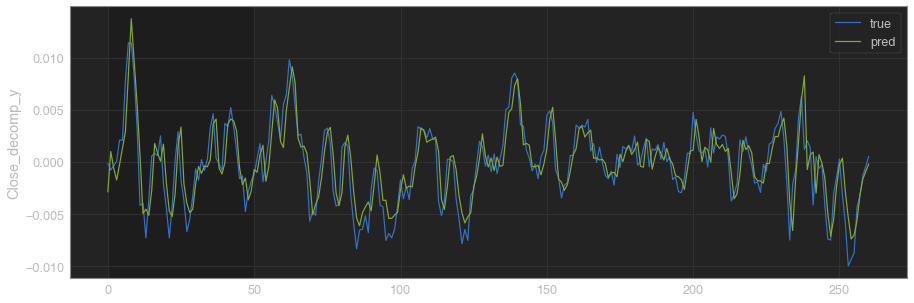

In [289]:
# Create Prediction
true, prediction = plot_comparison(start_idx=0, length=num_train, train=False)

In [290]:
# Transfer to DataFrame
df_result = pd.DataFrame([true[:, 0], prediction[:, 0]], index=['True', 'Predictions']).T
df_result['Difference'] = np.abs(df_result['True']-df_result['Predictions'])

In [291]:
# Find the optimal constant to adjust the return
# Write Function to find nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]
_constant = []
for x in np.arange(0.8, 1.2, step=0.0001):
    adj_return = df_result['Predictions'][:-1] * x
    _diff = df_result['True'][:-1] - adj_return
    _constant.append((x, _diff[:-1].std()))
_constant = pd.DataFrame(_constant)
idx_constant, nearest_value = find_nearest(_constant[1], 0)
constant = _constant[0][idx_constant]
df_result['Predictions'] = df_result['Predictions'] * constant
df_result['Difference'] = df_result['True'] - df_result['Predictions']

In [292]:
# Result summary
print(tabulate(df_result.describe(), headers='keys'))

                True    Predictions     Difference
-----  -------------  -------------  -------------
count  261            261            261
mean    -0.000169786   -7.05262e-05   -9.926e-05
std      0.00372183     0.00315874     0.0019696
min     -0.00994671    -0.00721993    -0.00687975
25%     -0.00234011    -0.00206026    -0.00134404
50%      0.000115793   -0.000103335    0.000130522
75%      0.00209828     0.00157729     0.00127393
max      0.0114108      0.0134362      0.00493479


In [293]:
# Metrics
truth = df_result['True']
predicted = df_result['Predictions']
rmse = np.round(np.sqrt(mean_squared_error(truth, predicted)), 4)
print('Root Mean Squared Error: ', rmse)
r2 = np.round(r2_score(truth, predicted)*100, 2)
print('R2 Score: ', r2)

Root Mean Squared Error:  0.002
R2 Score:  71.92


In [294]:
# Create a model for residual errors
window = freq
train_resid = df['Close_resid'][:num_train]
test_resid = df['Close_resid'][num_train:]
model_residual = AutoReg(train_resid, lags=window)
model_fit = model_residual.fit()
coef = model_fit.params
# Walk Forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_resid)+1):
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    if t < len(test_resid):
        history.append(df['Close_resid'][num_train+t])
    else:
        history.append(pred_error)

In [ ]:
# Convert to Price: non-stationary and random
price_pred = []
for i in range(num_test):
#     price = np.exp(
#         df_result['Predictions'][i]) * df['Close_AAPL'].iloc[-(num_test + 1 - i)] # log
    price  = df_result['Predictions'][i] * df['Close_AAPL'].iloc[-(num_test + 1 - i)] # Percent
    price_pred.append(price)
df_result.index = df['Close_AAPL'].iloc[-(num_test):].index
df_result['Price_True'] = df['Close_AAPL'].iloc[-(num_test):].values
df_result['Price_Predictions'] = price_pred
df_result['Price_Diff'] = np.abs(df_result['Price_True'] - df_result['Price_Predictions'])
print('df_result', '\n')
print(tabulate(df_result.describe(), headers='keys'))

In [295]:
# Convert to Price: stationary and non-random
price_pred = []
for i in range(num_test):
    price = df_result['Predictions'][i] + df['Close'].iloc[-(num_test - i + 1)] - df['Close_resid'].iloc[-(num_test - i + 1)] +\
            predictions[1:][i+1]
    price_pred.append(price)
df_result.index = df['Close'].iloc[-(num_test):].index
df_result['Price_True'] = df['Close'].iloc[-(num_test):].values
df_result['Price_Predictions'] = price_pred
df_result['Price_Diff'] = np.abs(df_result['Price_True'] - df_result['Price_Predictions'])
print('df_result', '\n')
print(tabulate(df_result.describe(), headers='keys'))

df_result 

                True    Predictions     Difference    Price_True    Price_Predictions    Price_Diff
-----  -------------  -------------  -------------  ------------  -------------------  ------------
count  261            261            261             261                  261          261
mean    -0.000169786   -7.05262e-05   -9.926e-05       0.88518              0.885544     0.00387538
std      0.00372183     0.00315874     0.0019696       0.0336026            0.0327733    0.00309393
min     -0.00994671    -0.00721993    -0.00687975      0.8023               0.80771      2.1529e-05
25%     -0.00234011    -0.00206026    -0.00134404      0.8604               0.862542     0.00157331
50%      0.000115793   -0.000103335    0.000130522     0.8898               0.890473     0.00296478
75%      0.00209828     0.00157729     0.00127393      0.907                0.904818     0.00559648
max      0.0114108      0.0134362      0.00493479      0.9569               0.955198     0.016623

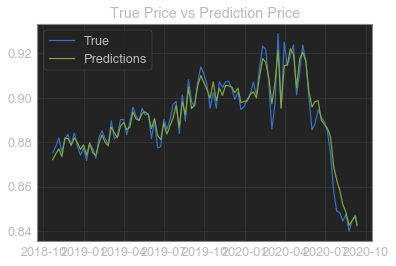

In [296]:
# Plot Price Prediction on Test Data
plt.plot(df_result['Price_True'][-100:], label='True')
plt.plot(df_result['Price_Predictions'][-100:], label='Predictions')
plt.title('True Price vs Prediction Price')
plt.legend()
plt.show()

In [297]:
# Price Predictions Metric
truth = df_result['Price_True']
predicted = df_result['Price_Predictions']
rmse = np.round(np.sqrt(mean_squared_error(truth, predicted)), 4)
print('Root Mean Squared Error: ', rmse)
r2 = np.round(r2_score(truth, predicted)*100, 2)
print('R2 Score: ', r2)

Root Mean Squared Error:  0.005
R2 Score:  97.82


In [298]:
# Stationary Price Predictions Metric
truth = df_result['Price_True'].diff(freq).dropna()
predicted = df_result['Price_Predictions'].diff(freq).dropna()
rmse = np.round(np.sqrt(mean_squared_error(truth, predicted)), 4)
print('Root Mean Squared Error: ', rmse)
r2 = np.round(r2_score(truth, predicted)*100, 2)
print('R2 Score: ', r2)

Root Mean Squared Error:  0.0071
R2 Score:  80.63


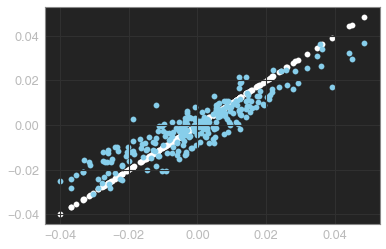

In [299]:
# Scatter Plot Predictions
plt.scatter(truth, truth, color='white')
plt.scatter(truth, predicted, color='skyblue')

# Predict Future

Predict Future

## Data Manipulation

In [300]:
# Data Manipulation for future prediction
# Get shifted Data
shifted_data = pd.DataFrame(df.iloc[-1, :][features]).T# Since all features are shifted data so there is need to further process this
# Fix Future Dating
if df_features.index.name == 'Datetime':
    _ = df_features.index[-1] + timedelta(minutes=5)
elif df_features.index.name == 'Date':
    for x in np.arange(5, 75, step=15, dtype=int):
        # Add days to the last day
        x = x.item()
        _ = df_features.index[-1] + timedelta(minutes=x)
        if _.weekday() < 5: # Repeat until it's working Monday-Friday
            break    
shifted_data.index = [_] # Add as index
del _
# Add future features
df_features_future = df_features.append(shifted_data)
print(tabulate(df_features_future.tail(), headers='keys'))

                       Open_decomp    High_decomp    Low_decomp    Close_decomp
-------------------  -------------  -------------  ------------  --------------
2020-08-24 00:00:00   -0.00416668    -0.00712552   -0.00676485     -0.00431422
2020-08-31 00:00:00   -0.00381245    -0.00190907   -0.00277332     -0.00320921
2020-09-07 00:00:00   -0.00070195    -0.00488417   -0.000754431    -0.00129011
2020-09-11 00:00:00   -0.000868922   -0.00035625   -0.0014074      -0.000411468
2020-09-11 00:05:00   -0.000868922   -0.000975516   4.76491e-05     0.00053578


## Prediction

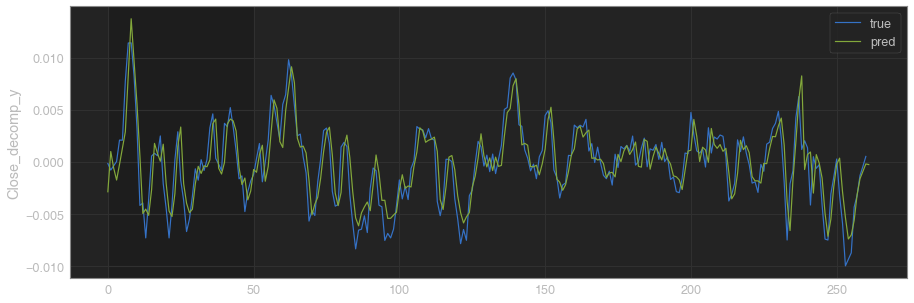

In [302]:
# Prediction
def predict_future(df_features_future=df_features_future,
                   start_idx=0,
                   length=100,
                   num_test=num_test):
    x_test_scaled = x_scaler.transform(
        df_features_future.iloc[-(num_test + 1):, :])
    x = x_test_scaled
    y_true = y_test
    # End-index for the sequences.
    end_idx = start_idx + length
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    # For each output-signal.
    for signal in range(len(target_signal)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15, 5))
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        # Plot labels etc.
        plt.ylabel(target_signal[signal])
        plt.legend()
        plt.show()
        return y_true, y_pred_rescaled
true_future, predict_future = predict_future(df_features_future=df_features_future, start_idx=0, length=1000)

In [303]:
# Compile Results
df_result_future = pd.DataFrame([true_future[:, 0], predict_future[:, 0]],
                                index=['True', 'Predictions']).T

In [304]:
# Write Function to find nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [305]:
# Find the optimal constant to adjust the return
_constant = []
for x in np.arange(0.8, 1.2, step=0.0001):
    adj_return = df_result_future['Predictions'][:-1] * x
    _diff = df_result_future['True'][:-1] - adj_return
    _constant.append((x, _diff[:-1].std()))
_constant = pd.DataFrame(_constant)
idx_constant, nearest_value = find_nearest(_constant[1], 0)
constant = _constant[0][idx_constant]
df_result_future['Predictions'] = df_result_future['Predictions'] * constant
df_result_future['Difference'] = df_result_future['True'] - df_result_future['Predictions']

In [306]:
# Create a model for residual errors
window = freq
train_resid = df['Close_resid'][:num_train]
test_resid = df['Close_resid'][num_train:]
model_residual = AutoReg(train_resid, lags=window)
model_fit = model_residual.fit()
coef = model_fit.params
# Walk Forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_resid)+2):
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    if t < len(test_resid):
        history.append(df['Close_resid'][num_train+t])
    else:
        history.append(pred_error)

In [307]:
# Convert to Price
price_pred = []
for i in range(num_test+1):
    price = df_result_future['Predictions'][i] + df['Close'].iloc[-(num_test - i + 1)] - df['Close_resid'].iloc[-(num_test - i + 1)] +\
            predictions[1:][i+1]
    price_pred.append(price)
df_result_future.index = df_features_future.iloc[-(num_test+1):].index
df_result_future['Price_True'] = np.append(df['Close'].iloc[-(num_test):].values, 0)
df_result_future['Price_Predictions'] = price_pred
df_result_future['Price_Diff'] = np.abs(df_result_future['Price_True'] - df_result_future['Price_Predictions'])
print('df_result', '\n')
print(tabulate(df_result_future.describe(), headers='keys'))

df_result 

                True    Predictions     Difference    Price_True    Price_Predictions     Price_Diff
-----  -------------  -------------  -------------  ------------  -------------------  -------------
count  261            262            261             262                   262         262
mean    -0.000169786   -7.11574e-05   -9.92745e-05     0.881801              0.885383    0.00707888
std      0.00372183     0.00315206     0.0019696       0.0641516             0.032815    0.0519422
min     -0.00994671    -0.00721845    -0.0068781       0                     0.807711    2.12098e-05
25%     -0.00234011    -0.00205131    -0.00134355      0.8604                0.861774    0.00157526
50%      0.000115793   -0.000115439    0.000130017     0.88975               0.890401    0.00296764
75%      0.00209828     0.00157599     0.00127422      0.90695               0.904808    0.00559811
max      0.0114108      0.0134335      0.00493537      0.9569                0.955196    0.8431

In [308]:
# Find the optimal constant to adjust prediction
_constant = []
for x in np.arange(0.8, 1.2000, step=0.0001):
    adj_price = df_result_future['Price_Predictions'][:-1] * x
    _diff = df_result_future['Price_True'][:-1] - adj_price
    _constant.append((x, _diff[:-1].mean()))
_constant = pd.DataFrame(_constant)
# Add the adjusted Price_Predictions to the df_result_future
idx_constant, nearest_value = find_nearest(_constant[1], 0)
constant = _constant[0][idx_constant]
df_result_future['Price_Predictions'] = df_result_future['Price_Predictions'] * constant
df_result_future['Price_Diff'] = df_result_future['Price_True'] - df_result_future['Price_Predictions']
print('df_result_future', '\n')
print(tabulate(df_result_future.iloc[:-1, :].describe(), headers='keys'))

df_result_future 

                True    Predictions     Difference    Price_True    Price_Predictions     Price_Diff
-----  -------------  -------------  -------------  ------------  -------------------  -------------
count  261            261            261             261                   261         261
mean    -0.000169786   -7.05118e-05   -9.92745e-05     0.88518               0.88519    -1.04536e-05
std      0.00372183     0.0031581      0.0019696       0.0336026             0.03276     0.00495282
min     -0.00994671    -0.00721845    -0.0068781       0.8023                0.807388   -0.0136374
25%     -0.00234011    -0.00205984    -0.00134355      0.8604                0.862196   -0.00281861
50%      0.000115793   -0.000103314    0.000130017     0.8898                0.890117    0.000359081
75%      0.00209828     0.00157697     0.00127422      0.907                 0.904456    0.00312902
max      0.0114108      0.0134335      0.00493537      0.9569                0.954814  

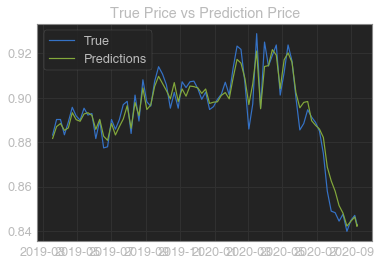

In [309]:
# Plot Price Prediction 
plt.plot(df_result_future['Price_True'].iloc[:-1,][-79:], label='True')
plt.plot(df_result_future['Price_Predictions'][-80:], label='Predictions')
plt.title('True Price vs Prediction Price')
plt.legend()
plt.show()

In [310]:
# Statement
truth = df_result_future['Price_True'].iloc[:-1].diff(freq).dropna()
predicted = df_result_future['Price_Predictions'].iloc[:-1].diff(freq).dropna()
print('Predictor Feature: ' + ', '.join(features))
print('One Step Ahead result is', df_result_future['Price_Predictions'][-1])
# Prediction R2 score
r2 = round(r2_score(truth, predicted) * 100, 2)
print('R2 score Price Prediction: ', r2, '%')

Predictor Feature: Open_decomp, High_decomp, Low_decomp, Close_decomp
One Step Ahead result is 0.8428083285880359
R2 score Price Prediction:  80.62 %


In [311]:
# Save Objects
# Put objects into dictionaries
if True:
    save_variables = {'Features': features, 'x_scaler': x_scaler, 'y_scaler': y_scaler, 'lag_freq': freq}
    if input('Do you want to save objects?(Yes/No) \n').upper() == 'YES':
        with open('AAPL-5min.pickle', 'wb') as f:
            pickle.dump(save_variables, f)
        model.save('RNN_AAPL-5min.h5')
        print('Saved object')
    else:
        print('Did not save object')

Do you want to save objects?(Yes/No) 
no
Did not save object


# Conclusion

In [82]:
# Statement
print('Predictor Feature: ' + ', '.join(features))
print('One Step Ahead result is', df_result_future['Price_Predictions'][-1])
print('R2 score Price Prediction: ', r2, '%')

Predictor Feature: Open_decomp
One Step Ahead result is 0.8442916702296586
R2 score Price Prediction:  91.56 %


# Confidence Interval

In [ ]:
# Add a confidence interval to the prediction
interval = {'top 1std':[], 'top 2std':[], 'top 3std':[], 'bottom 1std':[], 'bottom 2std':[], 'bottom 3std':[]}
for x in range(len(df_result_future['Price_Predictions'])):
    if x!= len(df_result_future)-1: # Do not include the last row
#         sigma = df_result_future['Price_Diff'].iloc[:-1].iloc[:x+1].std() # Cumulative
#         sigma = df_result_future['Price_Diff'].iloc[:-1].rolling(9).std()[x] # Rolling
        sigma = df_result_future['Price_Diff'].iloc[:-1].ewm(span=10).std()[x] # Exponential Weighted Stdev
        sigma = 0 if np.isnan(sigma) else sigma
    else:
        pass
    interval['top 1std'].append(df_result_future['Price_Predictions'][x] + 1*sigma)
    interval['bottom 1std'].append(df_result_future['Price_Predictions'][x] - 1*sigma)
    
    interval['top 2std'].append(df_result_future['Price_Predictions'][x] + 2*sigma)
    interval['bottom 2std'].append(df_result_future['Price_Predictions'][x] - 2*sigma)
    
    interval['top 3std'].append(df_result_future['Price_Predictions'][x] + 3*sigma)
    interval['bottom 3std'].append(df_result_future['Price_Predictions'][x] - 3*sigma)

In [ ]:
plt.figure(figsize=(20, 10))

# plt.plot(interval['top 1std'], label='1 std', color = 'pink')
# plt.plot(interval['bottom 1std'], label='1 std', color = 'pink')

plt.plot(interval['top 2std'], label='2 std', color = 'orange')
plt.plot(interval['bottom 2std'], label='2 std', color = 'orange')

# plt.plot(interval['top 99.9%'], label='1 std', color = 'white')
# plt.plot(interval['bottom 99.9%'], label='1 std', color = 'white')

plt.plot(df_result_future['Price_Predictions'].values, color='red', label='Predictions', marker='o')
plt.plot(df_result_future['Price_True'].iloc[:-1].values, color='green', label='Truth', marker='o')
plt.legend()
plt.show()

In [ ]:
df_result_future['Upper limit 1std'] = interval['top 1std']
df_result_future['Lower limit 1std'] = interval['bottom 1std']

df_result_future['Upper limit 2std'] = interval['top 2std']
df_result_future['Lower limit 2std'] = interval['bottom 2std']

df_result_future['Upper limit 3std'] = interval['top 3std']
df_result_future['Lower limit 3std'] = interval['bottom 3std']

In [ ]:
((df_result_future['Upper limit 1std'] > df_result_future['Price_True']) & (df_result_future['Lower limit 1std'] < df_result_future['Price_True'])).value_counts()

In [ ]:
conditions = [
    (((df_result_future['Price_True'] - df_result_future['Price_True'].shift(1)) *
    (df_result_future['Price_Predictions'] - df_result_future['Price_True'].shift(1))) > 0),
    (((df_result_future['Price_True'] - df_result_future['Price_True'].shift(1)) *
    (df_result_future['Price_Predictions'] - df_result_future['Price_True'].shift(1))) < 0) 
]
choices = ['True', 'False']

In [ ]:
df_result_future['Directions'] = np.select(conditions, choices, default='Same')
df_result_future['Directions'][-1] = 'Same'
df_result_future['True_Price_Change'] = (df_result_future['Price_True'] - df_result_future['Price_True'].shift(1))
df_result_future['Predictions_Price_Change'] = (df_result_future['Price_Predictions'] - df_result_future['Price_True'].shift(1))

In [ ]:
_dt = df_result_future.loc['2020-09-08'].between_time('10:00', '15:00')
profit = np.abs(_dt[_dt['Directions']=='True']['True_Price_Change']).sum()
loss = np.abs(_dt[_dt['Directions']=='False']['True_Price_Change']).sum()

In [ ]:
profit-loss

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(_dt[_dt['Directions']=='False']['Price_Diff'])
plt.hist(_dt[_dt['Directions']=='True']['Price_Diff'])
plt.show()

In [ ]:
df_result_future.loc['2020-09-08'].between_time('10:00', '15:00')['Directions'].value_counts()